# MERS (2012-2019)

### Dependencies

In [1]:
# Dependencies and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import requests
import gmaps
import os
import time
import datetime
import json
import datetime
import matplotlib
import matplotlib.dates as mdates
import calendar

from matplotlib.pyplot import figure
from scipy.stats import linregress

# Import API key
from api_keys import g_key

#Access maps with unique API key
gmaps.configure(api_key=g_key)

### Project MERS dataset
* Source: https://www.kaggle.com/imdevskp
##### Note: data has already been cleaned by author

In [2]:
# Study data files
country_count = "MERS Resources/country_count_latest.csv"
mers_weekly = "MERS Resources/weekly_clean.csv"

# Read the MERS data
mers_ByCountry = pd.read_csv(country_count) # Number of cases by Country
mers_PerWeek = pd.read_csv(mers_weekly) # Number of cases per week by Region

#Display of MERS data by Country
mers_PerWeek

,Year,Week,Region,New Cases
0,2012,12,Other Countries,1
1,2012,12,Republic of Korea,0
2,2012,12,Saudi Arabia,0
3,2012,13,Other Countries,0
4,2012,13,Republic of Korea,0
...,...,...,...,...
1123,2019,23,Republic of Korea,0
1124,2019,23,Saudi Arabia,1
1125,2019,24,Other Countries,0
1126,2019,24,Republic of Korea,0


In [3]:
# Number of affected countries
mers_count1 = len(mers_PerWeek["Region"].unique())
print(f"{mers_count1} regions were affected by MERS")

3 regions were affected by MERS


In [4]:
# Sum all confirmed cases
mers_sum1 = mers_PerWeek["New Cases"].sum()
print(f"There are {mers_sum1} confirmed cases")

There are 2447 confirmed cases


In [5]:
# Group by Date

# Merging format Year-Week into format of Date (Year-Month_Day)

# Splitting Year and Week columns
YearWeeks = mers_PerWeek.loc[:,"Year":"Week"] 

from datetime import datetime, timedelta, date 

def tofirstdayinisoweek(year, week): 
    ret = datetime.strptime('1-%02d-%04d' % (week, year), '%w-%W-%Y').date() 
    if date(year, 1, 4).isoweekday() > 4: 
        ret -= timedelta(days=7) 
    return ret 

def tomonthisoweek(year, week): 
    ret = datetime.strptime('1-%01d-%04d' % (week, year), '%w-%W-%Y').date() 
    ret = ret.strftime("%Y-%m")
    return ret 

# Creating lists to save the formats
Days = [] 
DayAbrev = []

# This loop will change the format from weeks to months/days and from weeks to months
for i in YearWeeks.index: 
    day = tofirstdayinisoweek(YearWeeks["Year"][i],YearWeeks["Week"][i]) 
    DayAbrev.append(day.strftime("%Y-%b-%d"))
    Days.append(day) 
    
Month = [] 
for i in YearWeeks.index: 
    month = tomonthisoweek(YearWeeks["Year"][i],YearWeeks["Week"][i]) 
    Month.append(month) 

mers_PerWeek['Date'] = Days 
mers_PerWeek['DateAbrev'] = DayAbrev
mers_PerWeek['Year and Month'] = Month 

mers_PerWeek.head()

,Year,Week,Region,New Cases,Date,DateAbrev,Year and Month
0,2012,12,Other Countries,1,2012-03-19,2012-Mar-19,2012-03
1,2012,12,Republic of Korea,0,2012-03-19,2012-Mar-19,2012-03
2,2012,12,Saudi Arabia,0,2012-03-19,2012-Mar-19,2012-03
3,2012,13,Other Countries,0,2012-03-26,2012-Mar-26,2012-03
4,2012,13,Republic of Korea,0,2012-03-26,2012-Mar-26,2012-03


In [6]:
mers_PerWeekTotal = mers_PerWeek.groupby(by="Date").sum()
mers_PerWeekTotal.head()

,Year,Week,New Cases
Date,,,
2012-03-19,6036,36,1
2012-03-26,6036,39,0
2012-04-02,6036,42,1
2012-04-09,6036,45,0
2012-04-16,6036,48,0


### Plotting MERS cases vs Time

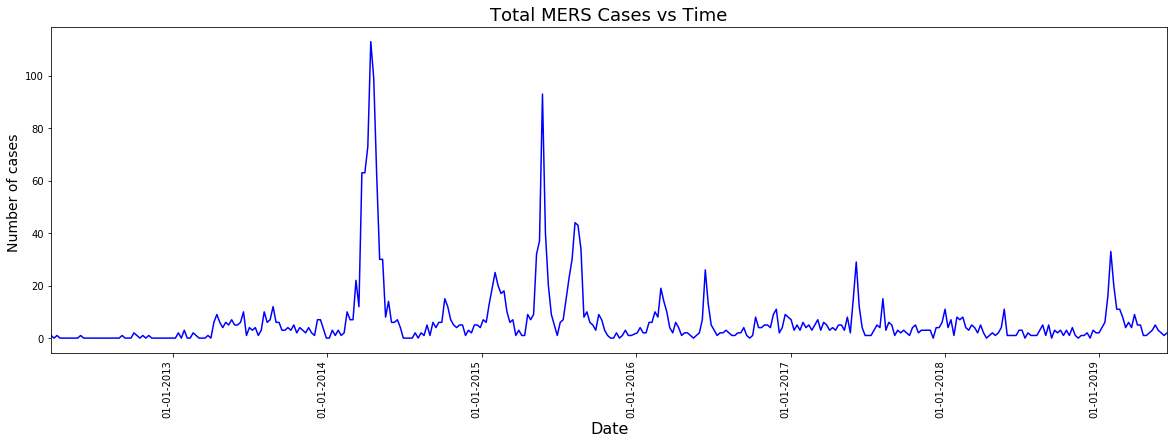

In [7]:
# Plotting MERS cases over Time
figure(num=None, figsize=(20,6))
ax = plt.gca()

mers_PerWeekTotal.reset_index().plot(kind='line',x='Date',y='New Cases',ax=ax, color='b')
plt.setp(ax.get_xticklabels(), rotation=90, ha="right") #Change orientation of tick labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y')) #Defining format
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Number of cases ", fontsize=14)
ax.set_title("Total MERS Cases vs Time", fontsize=18)
ax.get_legend().remove()
ax.set_xlim(mers_PerWeekTotal.index[0], mers_PerWeekTotal.index[-1])

plt.show()

In [8]:
#Defining x, y variable to plott by Region
saudi_date = mers_PerWeek.loc[mers_PerWeek["Region"]=="Saudi Arabia",["Date"]]
saudi_cases = mers_PerWeek.loc[mers_PerWeek["Region"]=="Saudi Arabia",["New Cases"]]
saudi_month = mers_PerWeek.loc[mers_PerWeek["Region"]=="Saudi Arabia",["Year and Month"]]
saudi_year = mers_PerWeek.loc[mers_PerWeek["Region"]=="Saudi Arabia",["Year"]]
saudi = pd.DataFrame({"Date":saudi_date["Date"],"Year and Month":saudi_month["Year and Month"],"Year":saudi_year["Year"],"Cases":saudi_cases["New Cases"]})

korea_date = mers_PerWeek.loc[mers_PerWeek["Region"]=="Republic of Korea",["Date"]]
korea_cases = mers_PerWeek.loc[mers_PerWeek["Region"]=="Republic of Korea",["New Cases"]]
korea = pd.DataFrame({"Date":korea_date["Date"],"Cases":korea_cases["New Cases"]})

other_date = mers_PerWeek.loc[mers_PerWeek["Region"]=="Other Countries",["Date"]]
other_cases = mers_PerWeek.loc[mers_PerWeek["Region"]=="Other Countries",["New Cases"]]
other = pd.DataFrame({"Date":other_date["Date"],"Cases":other_cases["New Cases"]})

saudi

,Date,Year and Month,Year,Cases
2,2012-03-19,2012-03,2012,0
5,2012-03-26,2012-03,2012,0
8,2012-04-02,2012-04,2012,0
11,2012-04-09,2012-04,2012,0
14,2012-04-16,2012-04,2012,0
...,...,...,...,...
1115,2019-05-13,2019-05,2019,5
1118,2019-05-20,2019-05,2019,3
1121,2019-05-27,2019-06,2019,2
1124,2019-06-03,2019-06,2019,1


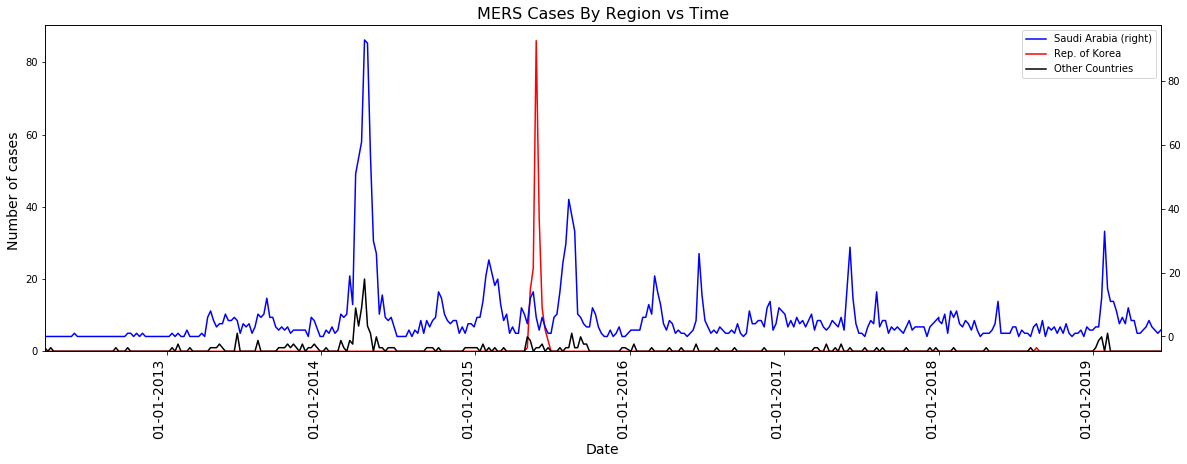

In [31]:
# Plotting MERS cases over Time
plt.figure(figsize=(20,6))
ax = plt.gca()

saudi.plot.line(x='Date',y='Cases',ax=ax, color='b', secondary_y=True, label="Saudi Arabia")
korea.plot.line(x='Date',y='Cases',ax=ax, color='r', label="Rep. of Korea")
other.plot.line(x='Date',y='Cases',ax=ax, color='k', label="Other Countries")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y')) #Defining format
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=14) #Change orientation of tick labels
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Number of cases ", fontsize=14)
ax.set_title("MERS Cases By Region vs Time", fontsize=16)
ax.get_legend()
ax.set_ylim(0,)
plt.show()

In [10]:
mers_flight_data = "MERS Resources/MERS_SaudiArabia_2012-2019.csv"

mers_flights = pd.read_csv(mers_flight_data)
mers_flights

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,DEST_AIRPORT_ID,DEST,DEST_COUNTRY,DEST_COUNTRY_NAME,YEAR,MONTH
0,0,299664,0,7917,SV,Saudi Arabian Airlines Corp,12266,IAH,US,United States,14380,DMM,SA,Saudi Arabia,2012,3
1,0,612190,0,7770,SV,Saudi Arabian Airlines Corp,12266,IAH,US,United States,12472,JED,SA,Saudi Arabia,2012,3
2,0,20594,0,7894,SV,Saudi Arabian Airlines Corp,12266,IAH,US,United States,14645,RUH,SA,Saudi Arabia,2012,3
3,0,104515,0,7770,SV,Saudi Arabian Airlines Corp,12472,JED,SA,Saudi Arabia,12266,IAH,US,United States,2012,3
4,0,643806,0,6365,SV,Saudi Arabian Airlines Corp,12472,JED,SA,Saudi Arabia,12478,JFK,US,United States,2012,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,4596,429326,0,6365,SV,Saudi Arabian Airlines Corp,12478,JFK,US,United States,12472,JED,SA,Saudi Arabia,2019,1
1267,4641,183823,0,8327,SV,Saudi Arabian Airlines Corp,12472,JED,SA,Saudi Arabia,12892,LAX,US,United States,2019,8
1268,4689,368799,0,6365,SV,Saudi Arabian Airlines Corp,12472,JED,SA,Saudi Arabia,12478,JFK,US,United States,2019,1
1269,4968,258269,0,6365,SV,Saudi Arabian Airlines Corp,12472,JED,SA,Saudi Arabia,12478,JFK,US,United States,2019,8


In [11]:
#Grouping, counting and creating a new data set with the data to plot Flight per Month
grouped_mers_flights = mers_flights.groupby('YEAR')
mers_flight_date = grouped_mers_flights.count()
mers_flight_date = mers_flight_date.reset_index()

mers_flight_df = pd.DataFrame({"Year":mers_flight_date['YEAR'], "Flights per Month": mers_flight_date["PASSENGERS"]})

mers_flight_df

,Year,Flights per Month
0,2012,175
1,2013,158
2,2014,162
3,2015,179
4,2016,165
5,2017,166
6,2018,146
7,2019,120


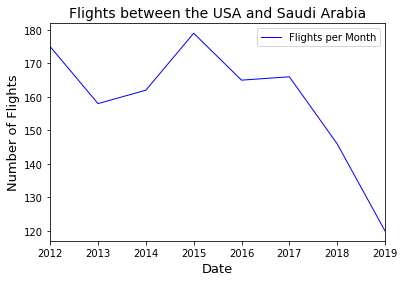

In [35]:
ax = plt.gca()
mers_flight_df.plot.line(x ='Year', y='Flights per Month',ax=ax, color='b', linewidth=1)
plt.title('Flights between the USA and Saudi Arabia', fontsize=14)
plt.ylabel("Number of Flights", fontsize=13)
plt.xlabel("Date", fontsize=13)
plt.xlim()

plt.show()

In [13]:
saudi_group = saudi.groupby(['Year']).sum()


In [14]:
merged_saudi_mers = pd.merge(saudi_group, mers_flight_df, on = ["Year"], how="inner")
merged_saudi_mers

,Year,Cases,Flights per Month
0,2012,5,175
1,2013,158,158
2,2014,659,162
3,2015,458,179
4,2016,247,165
5,2017,240,166
6,2018,138,146
7,2019,151,120


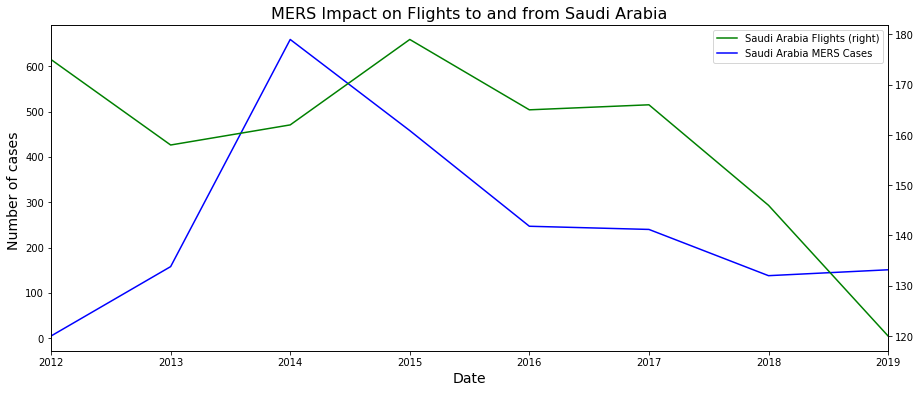

In [15]:
# Plotting the MERS cases vs Flights between US and Saudi Arabia (per month)
figure(num=None, figsize=(15,6))
ax = plt.gca()

merged_saudi_mers.plot.line(x='Year',y ='Flights per Month',ax=ax, color='green', secondary_y=True, label="Saudi Arabia Flights")
merged_saudi_mers.plot.line(x='Year',y ='Cases',ax=ax, color='b', label="Saudi Arabia MERS Cases")


#Aesthetics
plt.setp(ax.get_xticklabels(), ha="center") #Change orientation of tick labels
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y')) #Define date format
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Number of cases ", fontsize=14)
ax.set_title("MERS Impact on Flights to and from Saudi Arabia", fontsize=16)
plt.show()

The r-squared is: 0.2506479739286102
y = 0.02x + 153.08


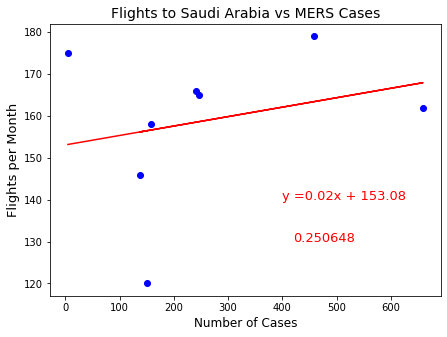

In [16]:
#Defining x and y
figure(num=None, figsize=(7,5))
x_values = merged_saudi_mers["Cases"]
y_values = merged_saudi_mers["Flights per Month"]

# Get slope, intercept from linregress() to plot y' = intercept + slope*x
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# Plot linear regression line.
y_pred = x_values * slope + intercept
equation = "y =" + str(round(slope,2)) + "x + " + str(round(intercept,2))
r2value = round(rvalue, 6)
print(f"The r-squared is: {rvalue}")
print(f'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2)))

#Plotting the scatter chart and line regression

plt.scatter(x_values,y_values, marker="o", color = "blue")
plt.plot(x_values,y_pred,"r-")

#Aaesthetics
plt.annotate(equation,(400,140),fontsize=13,color="red")
plt.annotate(r2value,(420,130),fontsize=13,color="red")
plt.title("Flights to Saudi Arabia vs MERS Cases", fontsize=14)
plt.xlabel("Number of Cases", fontsize=12)
plt.ylabel("Flights per Month", fontsize=13)

plt.show()

# MERS HeatMap

In [18]:
mers_ByCountry

,Country,Confirmed
0,Algeria,2
1,Austria,2
2,Bahrain,1
3,China,1
4,Egypt,1
5,France,2
6,Germany,3
7,Greece,1
8,Iran,6
9,Italy,1


In [24]:
lat_lng_csv = "citycoords.csv"
lat_lng_df = pd.read_csv(lat_lng_csv)
lat_lng_df = lat_lng_df.rename(columns={"name_long": "Country"})

countries_lat_lng = pd.merge(mers_ByCountry, lat_lng_df, on='Country')

# Access maps with unique API key
gmaps.configure(api_key=g_key)

locations = countries_lat_lng[["Latitude", "Longitude"]]

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=countries_lat_lng['Confirmed'], 
                                 dissipating=False, max_intensity=70,
                                 point_radius=5)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig


Figure(layout=FigureLayout(height='420px'))